In [8]:
import torch

In [9]:
print(torch.__version__)

2.6.0+cu126


In [10]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce GTX 1650


In [4]:
!nvidia-smi

Sat Mar  8 03:11:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.19                 Driver Version: 561.19         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0             14W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import torch
import torch.nn as nn

class SmallBalancedResNet(nn.Module):
    def __init__(self):
        super(SmallBalancedResNet, self).__init__()

        # First Convolution Layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Residual Blocks
        self.layer1 = self._make_layer(32, 64, 3, stride=2)  # 64 filters, 3 blocks
        self.layer2 = self._make_layer(64, 128, 3, stride=2)  # 128 filters, 3 blocks
        self.layer3 = self._make_layer(128, 256, 3, stride=2)  # 256 filters, 3 blocks

        # Global Average Pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layer (final output)
        self.fc = nn.Linear(256, 10)  # Output size adjusted to match smaller model

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(in_channels, out_channels, stride))
            in_channels = out_channels  # Update in_channels for next block
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # Initial conv + batch norm + relu
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)  # Global average pooling
        x = torch.flatten(x, 1)  # Flatten to feed to final layer
        x = self.fc(x)
        return x

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut skip
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))  # First convolution + batch norm + relu
        out = self.bn2(self.conv2(out))  # Second convolution + batch norm
        out += self.shortcut(x)  # Add the shortcut (residual)
        out = self.relu(out)  # Apply ReLU to the final result
        return out

# Create an instance of the model
model = SmallBalancedResNet()

# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


Total parameters: 4484394


In [2]:
from torchsummary import summary

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the model
model = SmallBalancedResNet()

# Move the model to the device
model = model.to(device)

# Get the model summary
summary(model, input_size=(3, 32, 32))  # CIFAR-10 images are 3x32x32



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          18,432
       BatchNorm2d-5           [-1, 64, 16, 16]             128
              ReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,864
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]           2,048
      BatchNorm2d-10           [-1, 64, 16, 16]             128
             ReLU-11           [-1, 64, 16, 16]               0
       BasicBlock-12           [-1, 64, 16, 16]               0
           Conv2d-13             [-1, 64, 8, 8]          36,864
      BatchNorm2d-14             [-1, 6

In [12]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")
print(f"Total parameters: {trainable_params + non_trainable_params}")


Trainable parameters: 4484394
Non-trainable parameters: 0
Total parameters: 4484394


In [3]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Data Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Epoch [1/8], Train Loss: 1.5287, Train Accuracy: 44.58%
Epoch [2/8], Train Loss: 1.1022, Train Accuracy: 61.36%
Epoch [3/8], Train Loss: 0.8857, Train Accuracy: 69.41%
Epoch [4/8], Train Loss: 0.7463, Train Accuracy: 74.30%
Epoch [5/8], Train Loss: 0.6405, Train Accuracy: 78.07%
Epoch [6/8], Train Loss: 0.5514, Train Accuracy: 80.97%
Epoch [7/8], Train Loss: 0.4789, Train Accuracy: 83.63%
Epoch [8/8], Train Loss: 0.4201, Train Accuracy: 85.55%
Training complete!


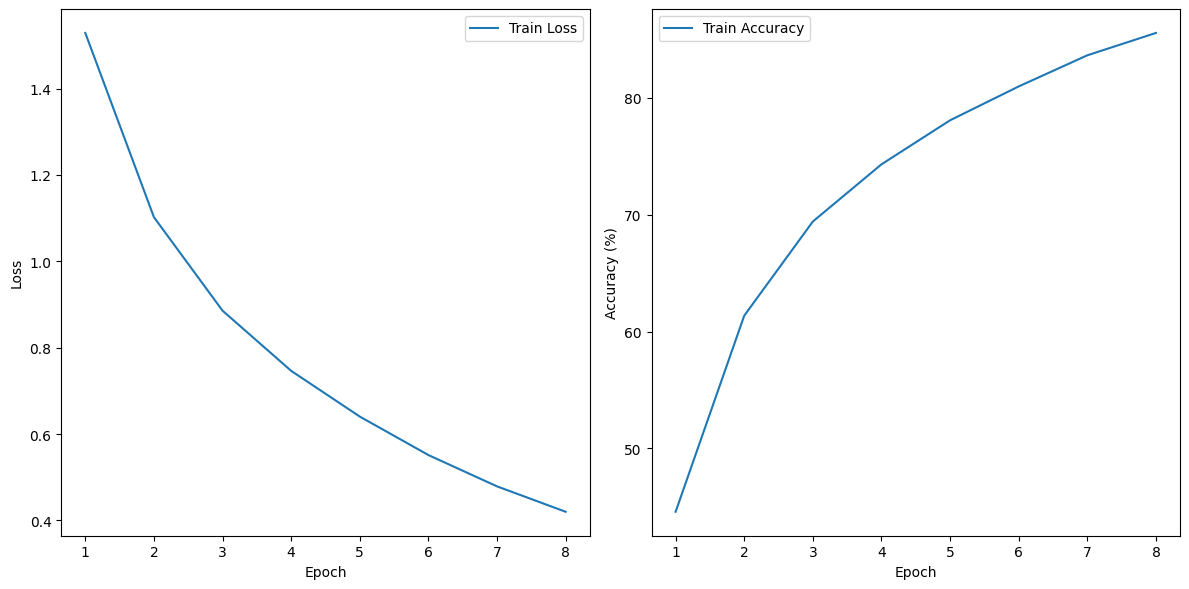

In [22]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallBalancedResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create lists to store training and validation loss and accuracy
train_losses = []
train_accuracies = []

# Define a function to calculate accuracy
def calculate_accuracy(loader, model, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # No need to compute gradients during validation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Training loop
num_epochs = 8
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute training loss and accuracy for this epoch
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total



    # Append the losses and accuracies for plotting later
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

print("Training complete!")

# Plotting the results
epochs = range(1, num_epochs + 1)

# Plot train and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Evaluate on test data
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 76.74%


In [24]:
num_more_epochs = 1  # Additional epochs

for epoch in range(10, 10 + num_more_epochs):  # Start from 25
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{10+num_more_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Continued Training Complete!")

Epoch [11/11], Loss: 0.3583
Continued Training Complete!


In [25]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 76.74%
